## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%cd ..

/mnt/d/anomaly-detection


In [3]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [4]:
window_length = 64
stride = 0

X = np.array([
    data.iloc[i - window_length:i].to_numpy().flatten()
    for i in range(window_length, data.shape[0] - window_length - stride)
]).reshape(-1, window_length, data.shape[1])

## Train model

In [5]:
from src.models.autoencoder import build_matrix_autoencoder
import keras

create_params = dict(
    input_shape=window_length,
    hidden_layers_size=[32],
    reg_strength=0.01,
    input_dropout=0.1,
)

compile_params = dict(
    optimizer=keras.optimizers.Adam(lr=0.1),
)

fit_params = dict(
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.2, verbose=1),
               keras.callbacks.EarlyStopping(min_delta=0.01, patience=20)]
)


model_fn = lambda: build_matrix_autoencoder(X.shape[2], create_params, compile_params)

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tssplit = TimeSeriesSplit(n_splits=3)
results = []

for i, (train_idx, test_idx) in enumerate(tssplit.split(X, X)):
    print(f'Fold {i}...')
    model = model_fn()

    squeeze = lambda els: list(map(lambda el: el.squeeze(), els))
    X_tr = squeeze(np.dsplit(X[train_idx], X.shape[2]))
    X_val = squeeze(np.dsplit(X[test_idx], X.shape[2]))
    
    
    history = model.fit(X_tr,
                        X_tr,
                        validation_data=(X_val, X_val),
                        **fit_params)
    results.append(history.history)

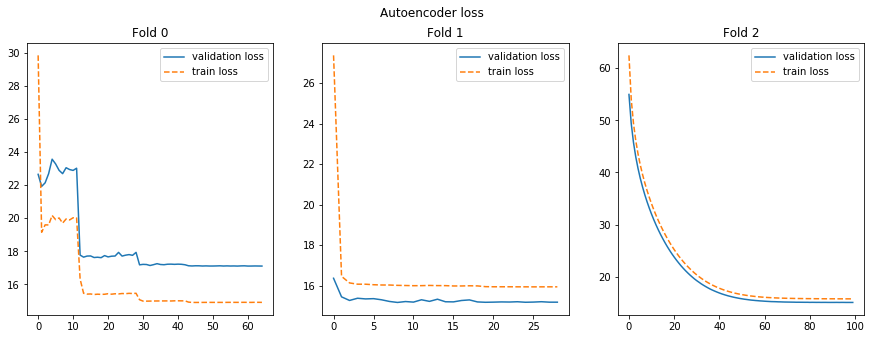

In [7]:
from src.visualization.visualize import visualize_result
visualize_result(results, f'Autoencoder loss')

In [ ]:
squeeze = lambda els: list(map(lambda el: el.squeeze(), els))
X_tr = squeeze(np.dsplit(X, X.shape[2]))

model = model_fn()
model.fit(X_tr, X_tr, **fit_params)
               
model.save('models/matrix_autoencoder.h5')

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_165 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_166 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_167 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_168 (InputLayer)          (None, 64)           0                                            
__________________________________________________________________________________________________
input_169 

## Extract first layer that can embedes data

In [ ]:
import keras
from keras.layers import Input
from keras.models import Model, load_model